# A comparison of Embedding space in Self-Supervised method and Supervised method

Each type of neural network has it's own way to embed the input data into another high-dimensional space.

- In this notebook i'll show a comparison on how different Self-Supervised methods we saw during the course Supervised Method embed their data and we will measure the goodness of those embeddings by applying some data mining technique.

### Disclaimer

Since we don't want to bias the result we will use same architecture defined in SimpleCNN class for all the method. The only difference will be the way we train the model.

In [1]:
from losses import *
from networks import SimpleCNN, SiameseNetwork


import pandas as pd
import seaborn as sns
import numpy as np
import random
import os
import torch
import torch.nn as nn
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt

# PCA
from sklearn.decomposition import PCA

# import mnist from torchvision
from torchvision import datasets, transforms

### Cuda to go faster

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading

In [3]:
class TripletDataset:

    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
        self.classes = list(set(mnist_dataset.targets.numpy()))
        self.class_to_images = {c: [] for c in self.classes}
        
        # Group images by class
        for i in range(len(mnist_dataset)):
            image, label = mnist_dataset[i]
            self.class_to_images[label].append(image)
        
    def __getitem__(self, index):
        anchor_image, anchor_label = self.mnist_dataset[index]
        
        # Select positive image from the same class
        positive_image = random.choice(self.class_to_images[anchor_label])
        
        # Select negative image from a different class
        negative_label = random.choice([c for c in self.classes if c != anchor_label])
        negative_image = random.choice(self.class_to_images[negative_label])
        
        return anchor_image, positive_image, negative_image
    
    
    def __len__(self):
        return len(self.mnist_dataset)
    
class SiameseMNIST:
    
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset

    def __getitem__(self, index):
        img1, label1 = self.mnist_dataset[index]
        should_get_same_class = np.random.randint(0, 2)
        if should_get_same_class:
            while True:
                index2 = np.random.randint(0, len(self.mnist_dataset))
                img2, label2 = self.mnist_dataset[index2]
                if label1 == label2:
                    break
        else:
            while True:
                index2 = np.random.randint(0, len(self.mnist_dataset))
                img2, label2 = self.mnist_dataset[index2]
                if label1 != label2:
                    break
        return (img1, img2), torch.tensor(int(label1 != label2), dtype=torch.float32)

    def __len__(self):
        return len(self.mnist_dataset)

In [4]:
# creating and loading dataset
mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

triplet_dataset = TripletDataset(mnist)
triplet_loader = torch.utils.data.DataLoader(triplet_dataset, batch_size=1024, shuffle=True)

In [5]:
# test a forward pass and print shapes
# networks are defined in networks.py in classes SimpleCNN and SiameseNetwork
model = SimpleCNN().to(device)

# taking a random sample from the dataset, we should get a tensor of shape [1, 32]
sample =  mnist[random.choice(range(len(mnist)))]
print(model.forward_once(sample[0].unsqueeze(0).to(device)).shape)

torch.Size([1, 32])


torch.Size([1024, 1, 28, 28]) torch.Size([1024, 1, 28, 28]) torch.Size([1024, 1, 28, 28])


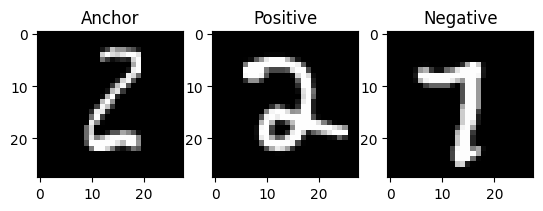

In [6]:
sample = next(iter(triplet_loader))
print(sample[0].shape, sample[1].shape, sample[2].shape)

# plot with matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)
axs[0].imshow(sample[0][0].squeeze(), cmap='gray')
axs[1].imshow(sample[1][0].squeeze(), cmap='gray')
axs[2].imshow(sample[2][0].squeeze(), cmap='gray')

# put legend 
axs[0].set_title('Anchor')
axs[1].set_title('Positive')
axs[2].set_title('Negative')

plt.show()

## First experiment: Triplet Loss

- Triplet Loss takes 3 images
  - Anchor
  - Positive
  - Negative

- The model is trained to minimize the distance between Anchor and Positive and maximize the distance between Anchor and Negative.

$$
\mathcal{L(x, x^+, x^-)} = \sum_{i=1}^{N} \max(0, ||f(x_i) - f(x_i^+)||^2 - ||f(x_i) - f(x_i^-)||^2 + \epsilon)
$$

**Sampling matters for performances**: we want to use hard samples, so those that are hard negative or hard positive.

In [7]:
# check for checkpoint
if os.path.exists('tripletmodel.pth'):
    tripletmodel = SimpleCNN()
    tripletmodel.load_state_dict(torch.load('tripletmodel.pth'))
    tripletmodel.eval()
    tripletmodel.to(device)
    triplet_train_loss = np.load('triplet_train_loss.npy')
    print('Model loaded')
else:
        
    tripletmodel = SimpleCNN()
    tripletloss = TripletLoss()


    optimizer = torch.optim.Adam(tripletmodel.parameters(), lr=1e-3)

    tripletmodel.to(device)
    triplet_train_loss = []

    for epoch in range(10):
        pbar = tqdm(triplet_loader)
        epoch_loss = 0
        for anchor, positive, negative in pbar:

            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            anchor_embedding = tripletmodel.forward_once(anchor)
            positive_embedding = tripletmodel.forward_once(positive)
            negative_embedding = tripletmodel.forward_once(negative)
            
            loss = tripletloss(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix_str(f'Loss {loss.item()}')
            triplet_train_loss.append(loss.item())
            
        print(f'Epoch {epoch}, Loss {epoch_loss/len(triplet_loader)}')

        
    # Save the model
    torch.save(tripletmodel.state_dict(), 'tripletmodel.pth')
    # save the loss
    np.save('triplet_train_loss.npy', triplet_train_loss)



Model loaded


In [8]:
tripletmodel.eval()
embeddings = []
labels = []

#take the first 1000 images
for i in range(5000):
    image, label = mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = tripletmodel.forward_once(image)
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())

embeddings_triplet = np.concatenate(embeddings, axis=0)


# ogni colonna del dataframe è una dimensione dell'embedding (x0, x1, x2, ..., x31) e l'ultima colonna è la label
df = pd.DataFrame(embeddings_triplet, columns=[f'x{i}' for i in range(embeddings_triplet.shape[1])])
df['label'] = labels

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,label
0,0.086927,-0.064906,0.014103,-0.246306,-0.028884,0.214030,0.028838,0.334310,-0.168058,0.457310,...,-0.237529,-0.249146,0.196399,-0.417208,-0.143440,0.310703,-0.088356,-0.174437,-0.589410,5
1,-0.169849,-0.413868,-0.990007,-0.955356,0.569353,-0.651112,-0.836783,-0.325650,-0.535583,-0.023627,...,0.180022,-0.139706,-0.658831,-0.233755,-0.196610,-0.241272,-0.025705,0.144125,-0.352465,0
2,-0.218774,0.320954,-0.541455,-0.152729,0.169646,-0.402169,-0.258324,-0.018139,-0.796053,-0.259158,...,0.554190,0.073053,-0.207250,0.321432,0.336983,-0.208655,0.304385,0.514448,-0.526237,4
3,0.018979,0.388348,-0.185842,0.072510,0.106057,0.109973,0.213789,-0.185094,-0.037748,0.217442,...,-0.033430,0.163349,-0.408661,0.207124,0.329785,0.308147,0.082012,0.234001,-0.345587,1
4,0.350521,0.083042,-0.206778,-0.428314,0.748300,-0.273398,-0.509785,0.363304,-1.069230,-0.092935,...,0.026650,-0.316623,-0.163979,-0.662015,-0.225757,-0.092683,-0.075155,-0.220885,-1.045781,9


In [9]:
# make pca and plot
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_embeddings_triplet = pca.fit_transform(embeddings_triplet)

df['pca1'] = pca_embeddings_triplet[:, 0]
df['pca2'] = pca_embeddings_triplet[:, 1]


#plt.figure(figsize=(12, 5))
#sns.scatterplot(data=df, x='pca1', y='pca2', hue='label', palette='tab10')

# Second Experiment: Siamese Network with Contrastive Loss

- Siamese Network takes 2 images and works similarly to Triplet Loss, but it's trained to minimize the distance between the two images.

- Runs two forward passes on the same network with the same weights on the images
- Apply the following loss function:

First compute a distance, can be L1 or L2 thats is differentiable (also cosine works) + linear ffw and nonlinearity ($\sigma$) to get a probability
$$
p(x_i, x_j) = \sigma(W |f(x_i) - f(x_j)|)
$$

Of course the loss will be on a Batch : $\mathcal{L}(B)$ but on two sample is something like:
$$
\mathcal{L(x_i, x_j)} = \mathbb{1}_{y_i = y_j} \log(p(x_i, x_j)) + \mathbb{1}_{y_i \neq y_j} \log(1 - p(x_i, x_j)) 
$$

## Big disadvantage of Siamese Network

- Since we need to forward pass the network twice, it's very slow to train, training on the same amount of data took 8 minutes instead the other two methods took around 1 minutes and 20 seconds. Without parallelization it's very slow.


In [10]:
mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

siamese_dataset = SiameseMNIST(mnist)

siamese_loader = torch.utils.data.DataLoader(siamese_dataset, batch_size=1024, shuffle=True)

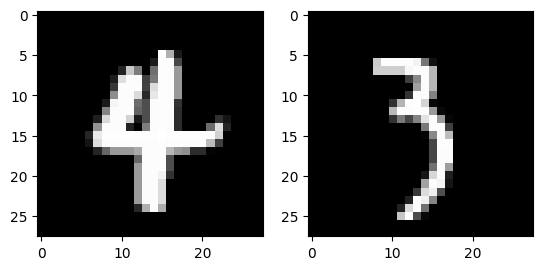

In [11]:
sample = next(iter(siamese_loader))

# show both positive and negative pair
fig, axs = plt.subplots(1, 2)
axs[0].imshow(sample[0][0][0].squeeze(), cmap='gray')
axs[1].imshow(sample[0][1][0].squeeze(), cmap='gray')


In [12]:
# check for checkpoint
if os.path.exists('siamese_network.pth'):
    siamese_network = SiameseNetwork()
    siamese_network.load_state_dict(torch.load('siamese_network.pth'))
    siamese_network.eval()
    siamese_network.to(device)
    siamese_train_loss = np.load('siamese_train_loss.npy')
    print('Model loaded')
else:

    siamese_network = SiameseNetwork()
    siamese_network.to(device)

    optimizer = torch.optim.Adam(siamese_network.parameters(), lr=1e-3)

    contrastive_loss = ContrastiveLoss()

    siamese_train_loss = []

    for epoch in range(10):
        
        pbar = tqdm(siamese_loader)
        epoch_loss = 0
        
        for (img1, img2), target in pbar:
            
            img1 = img1.to(device)
            img2 = img2.to(device)
            #label
            target = target.to(device)
            
            optimizer.zero_grad()
            output1, output2 = siamese_network(img1, img2)
            loss = contrastive_loss(output1, output2, target)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            pbar.set_postfix_str(f'Loss {loss.item()}')
            siamese_train_loss.append(loss.item())
            
        print(f'Epoch {epoch}, Loss {epoch_loss/len(siamese_loader)}')

    # Save the model
    torch.save(siamese_network.state_dict(), 'siamese_network.pth')
    # save the loss
    np.save('siamese_train_loss.npy', siamese_train_loss)


Model loaded


In [13]:
siamese_network.eval()

embeddings = []
labels = []

for i in range(5000):
    image, label = mnist[i]

    image = image.unsqueeze(0).to(device)
    #forward once
    embedding = siamese_network(image, image)[0]
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())
    
    
embeddings_siamese = np.concatenate(embeddings, axis=0)

df = pd.DataFrame(embeddings_siamese, columns=[f'x{i}' for i in range(embeddings_siamese.shape[1])])
df['label'] = labels

In [14]:
pca = PCA(n_components=2)

pca_embeddings_siamese = pca.fit_transform(embeddings_siamese)

df['pca1'] = pca_embeddings_siamese[:, 0]
df['pca2'] = pca_embeddings_siamese[:, 1]

#plt.figure(figsize=(12, 5))
#sns.scatterplot(data=df, x='pca1', y='pca2', hue='label', palette='tab10')

#plt.show()

# Baseline on Supervised Approach: SimpleCNN

- We will train a simple CNN on the dataset and extract the features from the last layer before the classification layer.

- The loss is the usual CrossEntropy Loss

In [15]:
mnist = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=1024, shuffle=True)

In [16]:
# Just classic train of CNN on MNIST

# check for checkpoint
if os.path.exists('baseline_model.pth'):
    model = SimpleCNN()
    model.to(device)
    model.load_state_dict(torch.load('baseline_model.pth'))
    baseline_train_loss = np.load('baseline_train_loss.npy')
    print('Model loaded')
else:

    model = SimpleCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    baseline_train_loss = []

    # send to device
    for epoch in range(10):
        pbar = tqdm(mnist_loader)
        epoch_loss = 0
        for image, label in pbar:

            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            output = model.forward_once(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix_str(f'Loss {loss.item()}')
            baseline_train_loss.append(loss.item())

        print(f'Epoch {epoch}, Loss {epoch_loss/len(mnist_loader)}')

    # Save the model
    torch.save(model.state_dict(), 'baseline_model.pth')
    # save the loss
    np.save('baseline_train_loss.npy', baseline_train_loss)
    

Model loaded


In [17]:
model.eval()

embeddings = []
labels = []

for i in range(5000):
    image, label = mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = model.forward_once(image)
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())
    
embeddings_baseline = np.concatenate(embeddings, axis=0)

df = pd.DataFrame(embeddings_baseline, columns=[f'x{i}' for i in range(embeddings_baseline.shape[1])])
df['label'] = labels

pca = PCA(n_components=2)

pca_embeddings_baseline = pca.fit_transform(embeddings_baseline)

df['pca1'] = pca_embeddings_baseline[:, 0]
df['pca2'] = pca_embeddings_baseline[:, 1]



## Visualizing the embeddings of our networks

- The Baseline (being a supervised method) has an hint of clustering but there the task is classification the clustering is naturally emerging from learning the task.

- The Siamese Network shows a very well separated clustering, since the semi-supervised task in our case we're trying to learn when two images are the same or not. So this makes our embeddings more separable.

- The Triplet Loss shows comparable clustering to Siamese, Triplet Loss is pushing the *Anchor-Positive* closer and *Anchor-Negative* further.


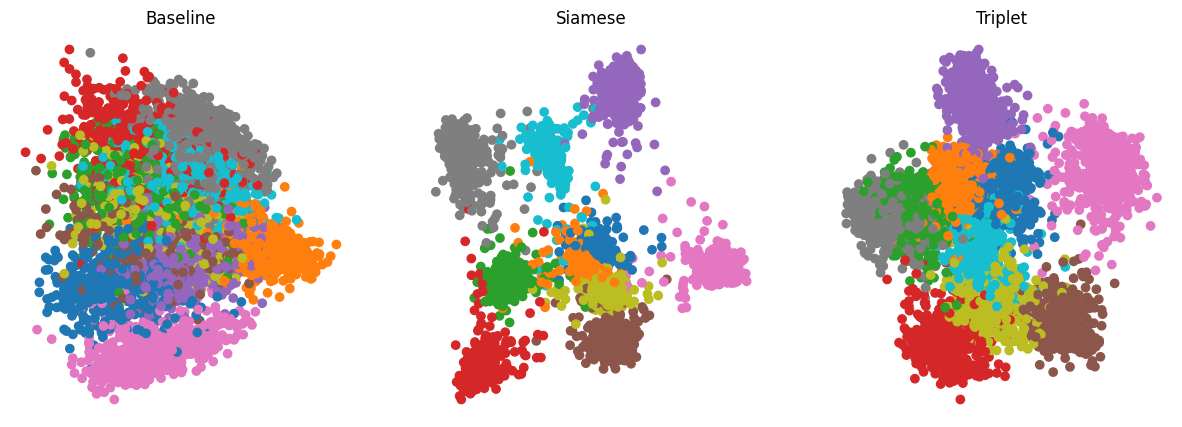

In [18]:
# show the embedding of each model in a subplot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

pca_embeddings = [pca_embeddings_baseline, pca_embeddings_siamese, pca_embeddings_triplet]

for i, (pca_embedding, title) in enumerate(zip(pca_embeddings, ['Baseline', 'Siamese', 'Triplet'])):
    axs[i].scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=labels, cmap='tab10')
    axs[i].set_title(title)
    axs[i].axis('off')
    
plt.show()




## Evaluating goodness of clustering

- We can use the **Silhouette Score** to evaluate the goodness of the clustering.
- Silhouette measure how a sample is similar to its own cluster compared to the other clusters.

Triplet Loss Silhouette Score: 0.5799902081489563
Siamese Loss Silhouette Score: 0.8011715412139893
Baseline Silhouette Score: 0.27866074442863464


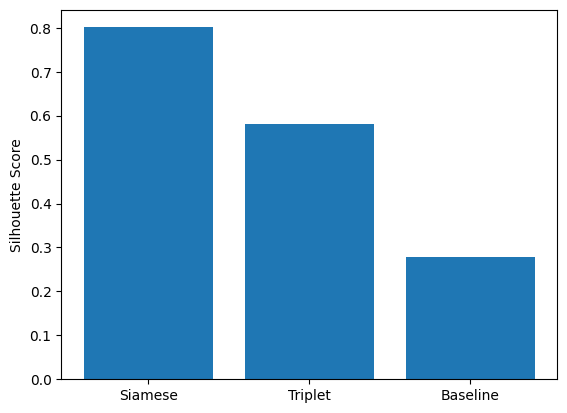

In [19]:

from sklearn.metrics import silhouette_score

triplet_score = silhouette_score(embeddings_triplet, labels)
print(f'Triplet Loss Silhouette Score: {triplet_score}')

siamese_score = silhouette_score(embeddings_siamese, labels)   
print(f'Siamese Loss Silhouette Score: {siamese_score}')

baseline_score = silhouette_score(embeddings_baseline, labels)
print(f'Baseline Silhouette Score: {baseline_score}')


# Bar chart order by silhouette score
scores = [siamese_score, triplet_score, baseline_score]

plt.bar(['Siamese', 'Triplet', 'Baseline'], scores)
plt.ylabel('Silhouette Score')
plt.show()


## On Convergence

- What can we say about the convergence of the methods?
- By this plot Siamese with Contrastive Loss seems to converge faster than the other two methods but the cost of the computation time is far higher than the other two methods. 
- At the end Triple Loss seems to converge to the same point taking much less time.

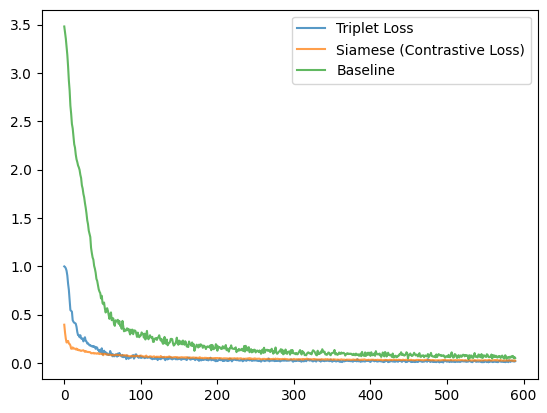

In [20]:
import matplotlib.pyplot as plt  # Ensure this import is correct

# plotting the losses
# add some alpha to the plot
plt.plot(triplet_train_loss, label='Triplet Loss', alpha=0.75)
plt.plot(siamese_train_loss, label='Siamese (Contrastive Loss)', alpha=0.75)
plt.plot(baseline_train_loss, label='Baseline', alpha=0.75)
plt.legend()

## Experimenting on FashionMNIST

- We will use the FashionMNIST dataset to train the models and extract the embeddings.

In [21]:
fashion_mnist = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

triplet_dataset = TripletDataset(fashion_mnist)
triplet_loader = torch.utils.data.DataLoader(triplet_dataset, batch_size=1024, shuffle=True)

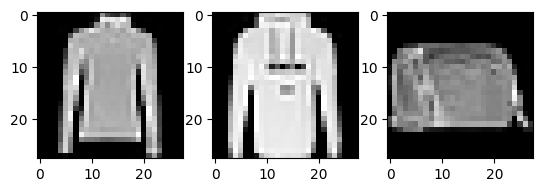

In [22]:
# show sample
sample = next(iter(triplet_loader))

fig, axs = plt.subplots(1, 3)
axs[0].imshow(sample[0][0].squeeze(), cmap='gray')
axs[1].imshow(sample[1][0].squeeze(), cmap='gray')
axs[2].imshow(sample[2][0].squeeze(), cmap='gray')

In [23]:
if os.path.exists('triplet_fashion_model.pth'):
    tripletmodel = SimpleCNN()
    tripletmodel.load_state_dict(torch.load('triplet_fashion_model.pth'))
    tripletmodel.eval()
    tripletmodel.to(device)
    triplet_fashion_train_loss = np.load('triplet_fashion_train_loss.npy')
    print('Model loaded')
else:

    tripletmodel = SimpleCNN()
    tripletloss = TripletLoss()

    optimizer = torch.optim.Adam(tripletmodel.parameters(), lr=1e-3)

    tripletmodel.to(device)
    triplet_train_loss = []

    for epoch in range(10):
        pbar = tqdm(triplet_loader)
        epoch_loss = 0
        for anchor, positive, negative in pbar:

            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            anchor_embedding = tripletmodel.forward_once(anchor)
            positive_embedding = tripletmodel.forward_once(positive)
            negative_embedding = tripletmodel.forward_once(negative)
            
            loss = tripletloss(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix_str(f'Loss {loss.item()}')
            triplet_train_loss.append(loss.item())
            
        print(f'Epoch {epoch}, Loss {epoch_loss/len(triplet_loader)}')

    # Save the model
    torch.save(tripletmodel.state_dict(), 'triplet_fashion_model.pth')
    # save the loss
    np.save('triplet_fashion_train_loss.npy', triplet_train_loss)
    

Model loaded


In [24]:

tripletmodel.eval()

embeddings = []
labels = []

for i in range(5000):
    image, label = fashion_mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = tripletmodel.forward_once(image)
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())
    
embeddings_triplet_fashion = np.concatenate(embeddings, axis=0)

df = pd.DataFrame(embeddings_triplet_fashion, columns=[f'x{i}' for i in range(embeddings_triplet_fashion.shape[1])])
df['label'] = labels

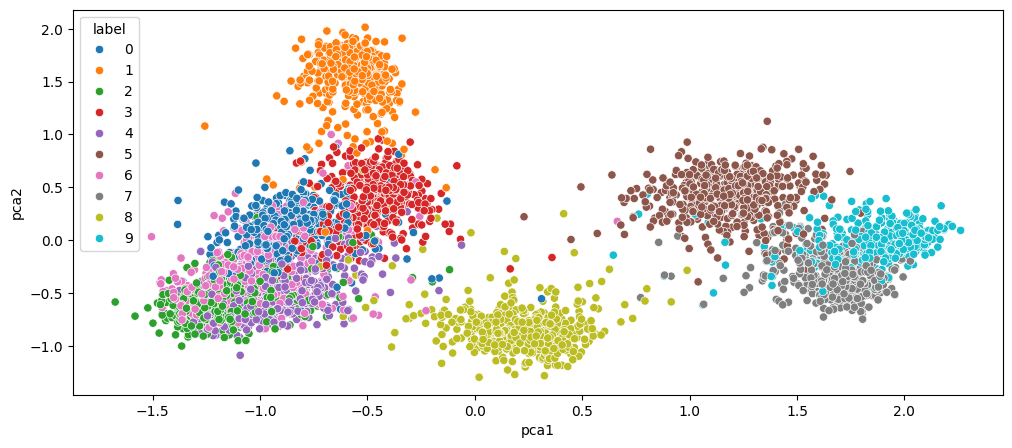

In [25]:
pca = PCA(n_components=2)

pca_embeddings_triplet_fashion = pca.fit_transform(embeddings_triplet_fashion)

df['pca1'] = pca_embeddings_triplet_fashion[:, 0]
df['pca2'] = pca_embeddings_triplet_fashion[:, 1]

plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='label', palette='tab10')

plt.show()


In [26]:
fascion_mnist = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

siamese_dataset = SiameseMNIST(fashion_mnist)

siamese_loader = torch.utils.data.DataLoader(siamese_dataset, batch_size=1024, shuffle=True)


Target: 0.0


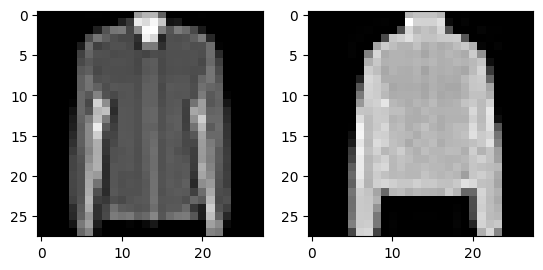

In [27]:
# show sample
sample = next(iter(siamese_loader))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(sample[0][0][0].squeeze(), cmap='gray')
axs[1].imshow(sample[0][1][0].squeeze(), cmap='gray')

# label 1 or 0 if the images are similar or not
label = sample[1][0].item()
print(f'Target: {label}')


In [28]:
tripletmodel.eval()
embeddings = []
labels = []

#take the first 1000 images
for i in range(5000):
    image, label = mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = tripletmodel.forward_once(image)
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())

embeddings_triplet = np.concatenate(embeddings, axis=0)


# ogni colonna del dataframe è una dimensione dell'embedding (x0, x1, x2, ..., x31) e l'ultima colonna è la label
df = pd.DataFrame(embeddings_triplet, columns=[f'x{i}' for i in range(embeddings_triplet.shape[1])])
df['label'] = labels

df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x23,x24,x25,x26,x27,x28,x29,x30,x31,label
0,-0.541317,-0.089772,0.380995,-0.493743,0.575783,-0.412831,0.023327,0.234427,-0.320988,0.649134,...,0.108804,-0.035310,0.352512,-0.264118,-0.275730,-0.372039,-0.427079,0.166886,0.192836,5
1,-0.532209,-0.080814,0.222789,-0.246381,0.735877,-0.801230,0.253410,0.351288,-0.251378,0.335527,...,0.218089,0.062252,0.589981,-0.003855,0.285844,-0.302885,-0.543638,-0.115348,-0.024713,0
2,0.157438,-0.015910,0.397379,-0.211093,0.246032,-0.392997,0.079387,0.234436,-0.239381,0.167719,...,-0.274400,0.118629,0.260145,-0.424385,-0.047681,0.315623,-0.335634,0.316849,0.414238,4
3,-0.003628,-0.038821,0.331366,-0.198520,0.513214,-0.463961,0.315735,0.050410,-0.552836,0.234260,...,0.027467,0.248233,0.444772,-0.497261,0.639245,-0.275841,-0.680800,0.084889,0.113282,1
4,-0.054944,0.020723,0.474255,-0.320952,0.567825,-0.500758,0.066788,0.068325,-0.377030,0.287852,...,-0.071926,0.180015,0.420825,-0.272615,0.164013,-0.121494,-0.434473,0.090285,0.198729,9


In [29]:
if os.path.exists('siamese_fashion_network.pth'):
    siamese_network = SiameseNetwork()
    siamese_network.load_state_dict(torch.load('siamese_fashion_network.pth'))
    siamese_network.eval()
    siamese_network.to(device)
    siamese_fashion_train_loss = np.load('siamese_fashion_train_loss.npy')
    print('Model loaded')
else:
        

    siamese_network = SiameseNetwork()

    siamese_network.to(device)

    optimizer = torch.optim.Adam(siamese_network.parameters(), lr=1e-3)

    contrastive_loss = ContrastiveLoss()

    siamese_train_loss = []

    for epoch in range(10):
            
            pbar = tqdm(siamese_loader)
            epoch_loss = 0
            
            for (img1, img2), target in pbar:
                
                img1 = img1.to(device)
                img2 = img2.to(device)
                target = target.to(device)
                
                optimizer.zero_grad()
                output1, output2 = siamese_network(img1, img2)
                loss = contrastive_loss(output1, output2, target)
        
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                pbar.set_postfix_str(f'Loss {loss.item()}')
                siamese_train_loss.append(loss.item())
                
            print(f'Epoch {epoch}, Loss {epoch_loss/len(siamese_loader)}')
            
    # Save the model
    torch.save(siamese_network.state_dict(), 'siamese_fashion_network.pth')
    # save the loss
    np.save('siamese_fashion_train_loss.npy', siamese_train_loss)
    

Model loaded


In [30]:
siamese_network.eval()

embeddings = []
labels = []

for i in range(5000):
    image, label = fashion_mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = siamese_network(image, image)[0]
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())
    
embeddings_siamese_fashion = np.concatenate(embeddings, axis=0)

df = pd.DataFrame(embeddings_siamese_fashion, columns=[f'x{i}' for i in range(embeddings_siamese_fashion.shape[1])])
df['label'] = labels


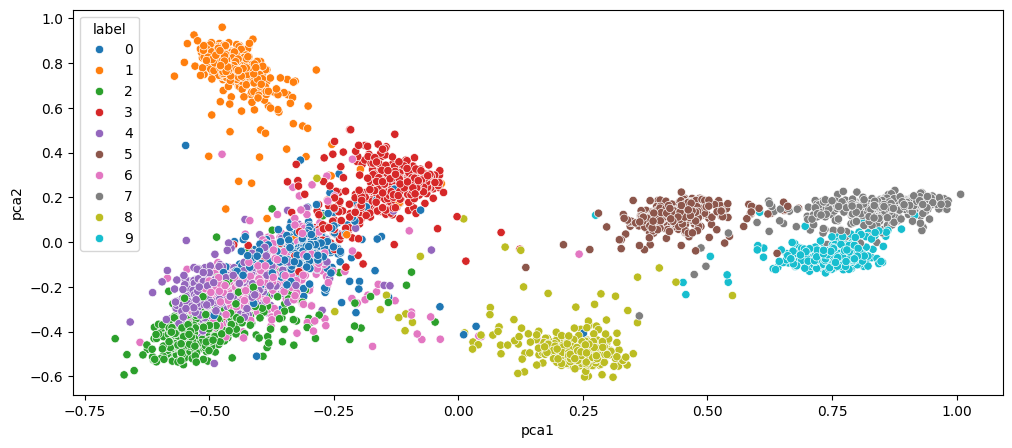

In [31]:
pca = PCA(n_components=2)

pca_embeddings_siamese_fashion = pca.fit_transform(embeddings_siamese_fashion)

df['pca1'] = pca_embeddings_siamese_fashion[:, 0]
df['pca2'] = pca_embeddings_siamese_fashion[:, 1]

plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='label', palette='tab10')

plt.show()



In [32]:
fashion_mnist = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

mnist_loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=1024, shuffle=True)


In [33]:
if os.path.exists('baseline_fashion_model.pth'):
    model = SimpleCNN()
    model.to(device)
    model.load_state_dict(torch.load('baseline_fashion_model.pth'))
    baseline_fashion_train_loss = np.load('baseline_fashion_train_loss.npy')
else:

        
    model = SimpleCNN().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    baseline_train_loss = []

    for epoch in range(10):
        pbar = tqdm(mnist_loader)
        epoch_loss = 0
        for image, label in pbar:

            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            output = model.forward_once(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            pbar.set_postfix_str(f'Loss {loss.item()}')
            baseline_train_loss.append(loss.item())

        print(f'Epoch {epoch}, Loss {epoch_loss/len(mnist_loader)}')
        
    # Save the model
    torch.save(model.state_dict(), 'baseline_fashion_model.pth')
    # save the loss
    np.save('baseline_fashion_train_loss.npy', baseline_train_loss)
    

In [34]:
model.eval()

embeddings = []
labels = []

for i in range(5000):
    image, label = fashion_mnist[i]

    image = image.unsqueeze(0).to(device)
    embedding = model.forward_once(image)
    labels.append(label)
    embeddings.append(embedding.cpu().detach().numpy())
    
embeddings_baseline_fashion = np.concatenate(embeddings, axis=0)

df = pd.DataFrame(embeddings_baseline_fashion, columns=[f'x{i}' for i in range(embeddings_baseline_fashion.shape[1])])
df['label'] = labels


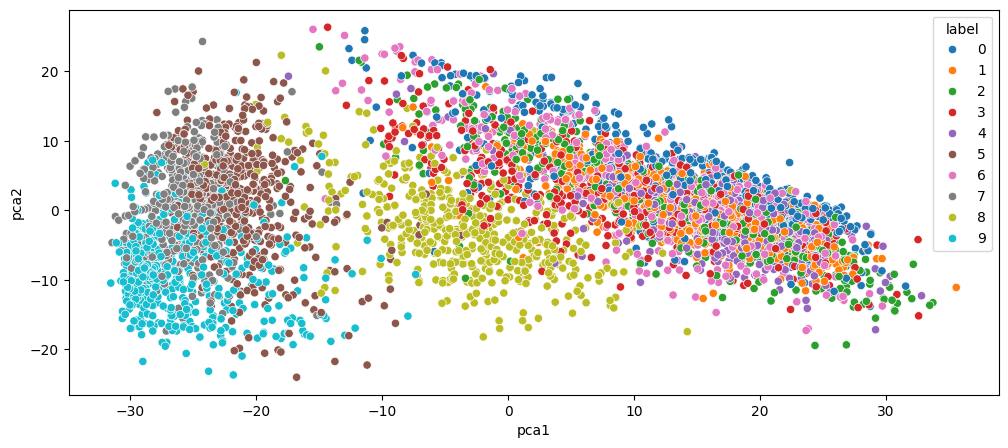

In [35]:
pca = PCA(n_components=2)

pca_embeddings_baseline_fashion = pca.fit_transform(embeddings_baseline_fashion)

df['pca1'] = pca_embeddings_baseline_fashion[:, 0]
df['pca2'] = pca_embeddings_baseline_fashion[:, 1]

plt.figure(figsize=(12, 5))
sns.scatterplot(data=df, x='pca1', y='pca2', hue='label', palette='tab10')

plt.show()


## Visualize embeddings scores on FashionMNIST

Triplet Loss Silhouette Score: 0.4188806712627411
Siamese Loss Silhouette Score: 0.5321846008300781
Baseline Silhouette Score: 0.1400822550058365


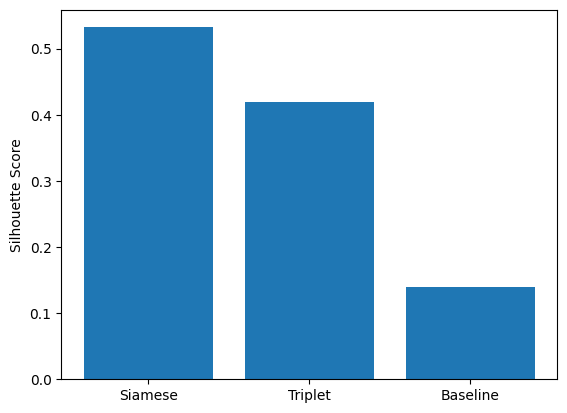

In [36]:
# Same silhouette score for the fashion mnist dataset

triplet_score = silhouette_score(embeddings_triplet_fashion, labels)
print(f'Triplet Loss Silhouette Score: {triplet_score}')

siamese_score = silhouette_score(embeddings_siamese_fashion, labels)
print(f'Siamese Loss Silhouette Score: {siamese_score}')

baseline_score = silhouette_score(embeddings_baseline_fashion, labels)
print(f'Baseline Silhouette Score: {baseline_score}')

scores = [siamese_score, triplet_score, baseline_score]

plt.bar(['Siamese', 'Triplet', 'Baseline'], scores)
plt.ylabel('Silhouette Score')
plt.show()


## Another losses comparison

Again we can see that Triplet Loss still can compete with Contrastive Loss.

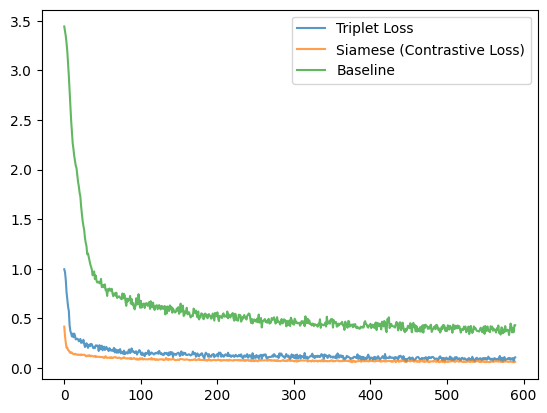

In [37]:
# plotting the losses
plt.plot(triplet_fashion_train_loss, label='Triplet Loss', alpha=0.75)
plt.plot(siamese_fashion_train_loss, label='Siamese (Contrastive Loss)', alpha=0.75)
plt.plot(baseline_fashion_train_loss, label='Baseline', alpha=0.75)

plt.legend()

## Embeddings on FashionMNIST

- Same as before, the two self-supervised method show very similar clustering with Siamese still getting better separed clusters.

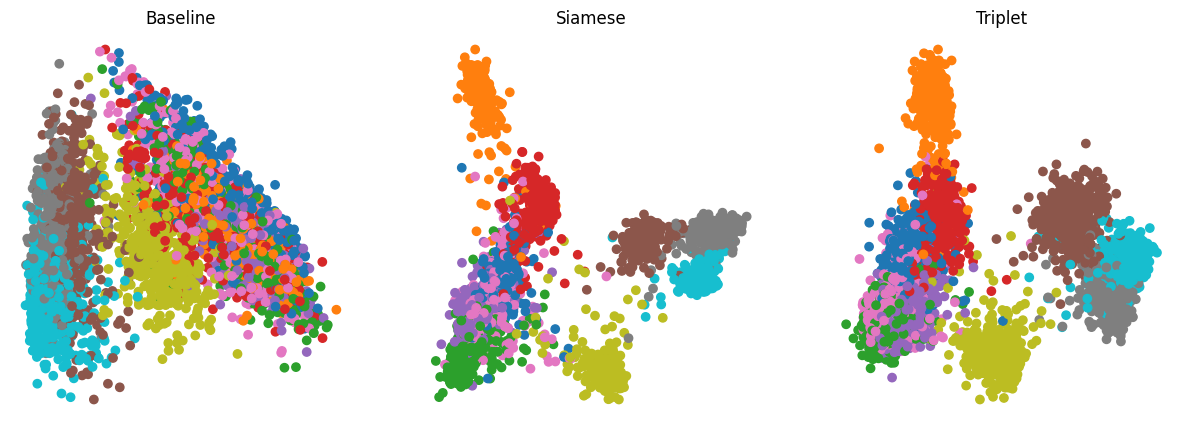

In [38]:
# show the embedding of each model in a subplot

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

pca_embeddings = [pca_embeddings_baseline_fashion, pca_embeddings_siamese_fashion, pca_embeddings_triplet_fashion]

for i, (pca_embedding, title) in enumerate(zip(pca_embeddings, ['Baseline', 'Siamese', 'Triplet'])):
    axs[i].scatter(pca_embedding[:, 0], pca_embedding[:, 1], c=labels, cmap='tab10')
    axs[i].set_title(title)
    axs[i].axis('off')
    
plt.show()


## Conclusion

- We can see that the two self-supervised methods are very good at extracting embeddings, we could use those embedding to train a classifier since they are well separated we can expect a good performance on the classification task.

- Siamese Network with Contrastive Loss is the best method in terms of clustering, but it's very slow to train.

- Triplet Loss is a good trade-off between speed and performance.
